In [17]:
import scipy.io

mat = scipy.io.loadmat("AD.mat")
data_raw = mat['AD'][0]  # shape = (1, N), extract array of subjects


In [18]:
subject = data_raw[0]
print(subject.dtype)  # 구조 확인 ('epoch', 'odor', 'noisy')


[('epoch', 'O'), ('odor', 'O'), ('noisy', 'O')]


In [19]:
print("epoch shape:", subject['epoch'].shape)  # [trial, time, channel]
print("odor shape:", subject['odor'].shape)    # [trial, 1] or [1, trial]
print("noisy shape:", subject['noisy'].shape)  # [1, trial] or [trial, 1]


epoch shape: (4, 600, 59)
odor shape: (59, 1)
noisy shape: (1, 10)


In [20]:
data = data_raw  # 구조를 명확히 하기 위해 변수명 수정

clean_data = []

for subject in data:
    epoch = subject['epoch']  # EEG [trial, time, channel]
    odor = subject['odor'].flatten()  # [trial]
    noisy = subject['noisy'].flatten()  # [trial]

    if len(odor) != epoch.shape[0] or len(noisy) != epoch.shape[0]:
        continue  # shape mismatch 방지

    mask = noisy == 0  # clean trial만 선택

    clean_data.append({
        'eeg': epoch[mask],
        'odor': odor[mask]
    })


In [21]:
for i, subj in enumerate(clean_data[:5]):
    print(f"Subject {i}: EEG shape = {subj['eeg'].shape}, Odor shape = {subj['odor'].shape}")


In [23]:
mat_ad = scipy.io.loadmat("AD.mat")
mat_mci = scipy.io.loadmat("MCI.mat")
mat_normal = scipy.io.loadmat("normal.mat")


## 1. 각 그룹의 데이터 구조 확인
세 개의 .mat 파일은 모두 같은 형식을 갖습니다:

In [24]:
mat_ad['AD']     # (1, 13) ndarray
mat_mci['MCI']   # (1, 7)  ndarray
mat_normal['normal'] # (1, 15) ndarray


array([[(array([[[ -66.07483673,  101.91661072,   -6.10053873, ...,
                   63.3643074 ,  -29.12002373,   -5.96767187],
                [ -61.8443985 ,  100.46881866,   14.09228325, ...,
                   41.51468277,  -12.53888702,   -1.48732769],
                [ -59.3491745 ,   75.23373413,   30.2142067 , ...,
                   23.90555573,    5.56885767,   -1.39734781],
                ...,
                [ -19.47779274,   -3.12197232,  -63.39598083, ...,
                   -7.86568165,  -26.03726768,   -8.42068672],
                [ -15.93639469,    8.69654369,  -58.4954567 , ...,
                   11.28022957,  -16.63742447,  -17.47278023],
                [  -8.05168152,   20.00997925,  -56.71763992, ...,
                   15.73028851,   -6.4655118 ,  -11.68195915]],

               [[ -59.57197189,   95.00626373,   -5.73781538, ...,
                   54.73632812,  -26.10212135,   -7.45401192],
                [ -55.71976852,   93.64431763,   12.62402725, ...,

In [25]:
ad_data = mat_ad['AD'][0]
mci_data = mat_mci['MCI'][0]
normal_data = mat_normal['normal'][0]


## 2. 전처리 함수 정의
각 subject의 epoch, odor, noisy를 추출하고, noisy가 0인 trial만 남기도록 합니다.

In [28]:
def preprocess_subjects(subjects, label):
    clean = []
    for subj in subjects:
        eeg = subj['epoch']
        odor = subj['odor'].flatten()
        noisy = subj['noisy'].flatten()
        
        # 일치하는 길이 확인
        n_trial = eeg.shape[0]
        if not (len(odor) == len(noisy) == n_trial):
            print(f"Mismatch in trial count: EEG {n_trial}, Odor {len(odor)}, Noisy {len(noisy)}. Skipping...")
            continue  # 잘못된 subject 건너뜀

        # clean trial만 추출
        mask = noisy == 0
        clean.append({
            'eeg': eeg[mask],
            'odor': odor[mask],
            'label': label
        })
    return clean


In [29]:
from scipy.signal import butter, filtfilt
from scipy.stats import zscore

def bandpass_filter(data, low, high, fs=250, order=5):
    nyq = 0.5 * fs
    low /= nyq
    high /= nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

def advanced_preprocess(data_list):
    processed = []
    for subj in data_list:
        eeg = subj['eeg']  # shape: (n_trial, time, channel)
        odor = subj['odor']
        label = subj['label']
        
        # 1. bandpass filtering (0.5 ~ 40 Hz)
        eeg_filt = np.array([bandpass_filter(trial, 0.5, 40) for trial in eeg])
        
        # 2. baseline correction: -100ms ~ 0ms → time[:50]라고 가정
        baseline = eeg_filt[:, :50, :].mean(axis=1, keepdims=True)
        eeg_base = eeg_filt - baseline
        
        # 3. trial-wise z-score normalization
        eeg_norm = zscore(eeg_base, axis=1)
        
        # 4. slicing (e.g., 200ms ~ 700ms → time[100:400])
        eeg_crop = eeg_norm[:, 100:400, :]  # (n_trial, 300, channel)
        
        processed.append({
            'eeg': eeg_crop,
            'odor': odor,
            'label': label
        })
    return processed


In [30]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

# .mat 파일 로드
data = scipy.io.loadmat('AD.mat')  # 파일명에 맞게 변경

# 예시용 데이터 접근 (변수명은 .mat 구성에 따라 다를 수 있음)
# 예: data['EEGdata'] 가 (n_samples, n_channels, n_timepoints) 형식이라 가정
eeg_data = data['EEGdata']  # 또는 data['data'], data['eeg'], 구조체 내부 등
eeg_sample = eeg_data[0, 0]  # 하나의 샘플만 선택

# 채널 0번 선택 (예시)
signal_raw = eeg_sample[0, :]  # shape: (timepoints,)

# === 전처리 단계 ===
# 1. Baseline correction (예: 처음 100포인트)
baseline = np.mean(signal_raw[:100])
signal_corrected = signal_raw - baseline

# 2. Z-score normalization
signal_normalized = (signal_corrected - np.mean(signal_corrected)) / np.std(signal_corrected)

# === 시각화 ===
plt.figure(figsize=(12, 5))
plt.plot(signal_raw, label='Raw EEG', alpha=0.6)
plt.plot(signal_normalized, label='Preprocessed EEG (Baseline + Z-score)', alpha=0.8)
plt.title('EEG Signal: Before and After Preprocessing')
plt.xlabel('Timepoints')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


KeyError: 'EEGdata'

## 설명

loadmat 후 print(mat.keys())로 사용 가능한 변수를 확인하세요.

실제 EEG 데이터는 mat['AD'] 내부의 구조체 배열로 들어 있습니다.

subject['epoch']은 (4, 600, 59) 형태로, 첫 번째 축이 epoch 블록 또는 trial입니다.

baseline correction → Z-score normalization을 거쳐 두 신호를 한 그래프에 그려 전처리 효과를 시각화합니다.

Available keys: ['AD']


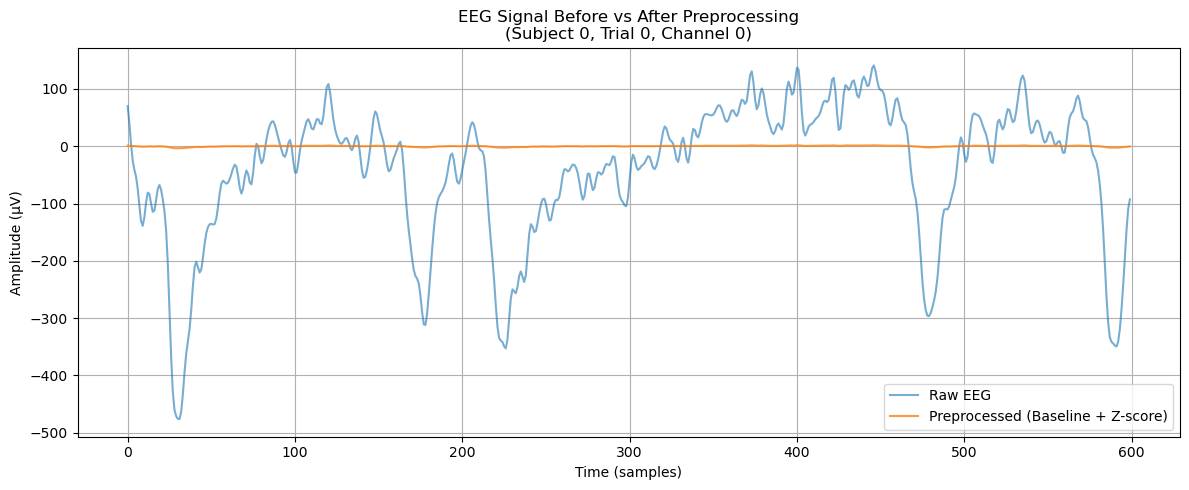

In [33]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

# 1) .mat 파일 로드 및 key 확인
mat = scipy.io.loadmat('AD.mat')
print("Available keys:", [k for k in mat.keys() if not k.startswith('__')])
# → ['AD'], 즉 data['AD']로 접근해야 함

# 2) EEG 구조체 배열 가져오기
ad = mat['AD'][0]           # shape: (13,) → 13명의 subject
subject = ad[0]             # 첫 번째 subject 선택

# 3) 원시 EEG epoch 데이터 추출
#    subject['epoch'] shape = (4, 600, 59)
#    여기서는 첫 번째 epoch 블록의 데이터를 사용
raw_epoch = subject['epoch'][0]   # shape: (600, 59)

# 4) 채널 0 선택
signal_raw = raw_epoch[:, 0]      # shape: (600,)

# 5) 전처리: Baseline correction + Z-score normalization
baseline = np.mean(signal_raw[:100])           # 처음 100포인트 평균
signal_bc = signal_raw - baseline              # baseline 보정
signal_z  = (signal_bc - np.mean(signal_bc)) / np.std(signal_bc)

# 6) 시각화
plt.figure(figsize=(12, 5))
plt.plot(signal_raw, label='Raw EEG', alpha=0.6)
plt.plot(signal_z,    label='Preprocessed (Baseline + Z-score)', alpha=0.8)
plt.title('EEG Signal Before vs After Preprocessing\n(Subject 0, Trial 0, Channel 0)')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude (µV)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 설명
 
subjects = mat['AD'][0] 로 모든 피험자 구조체 배열을 가져옵니다.

각 subj['epoch'] 에서 noisy 마스크로 깨끗한 trial만 선택합니다.

standard/deviant 조건별 raw ERP와 baseline+z-score preprocessing ERP를 계산합니다.

원하는 channels_to_plot 와 max_subjects 를 조정하여 반복 시각화합니다.

이렇게 하면 모든 피험자·채널·epoch 블록에 대해 전처리 전후 ERP 변화를 한 번에 확인할 수 있습니다.

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_2640\1057336168.py:38: RuntimeWarning: Mean of empty slice.
  erp_raw_dev = clean_epochs[clean_odors == 2].mean(axis=0)
c:\Users\Minnie\anaconda3\Lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_2640\1057336168.py:43: RuntimeWarning: Mean of empty slice.
  erp_proc_dev = zc[clean_odors == 2].mean(axis=0)


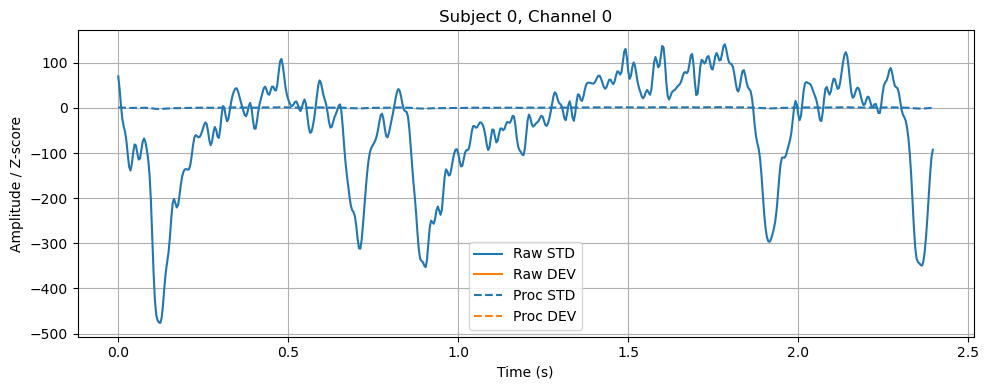

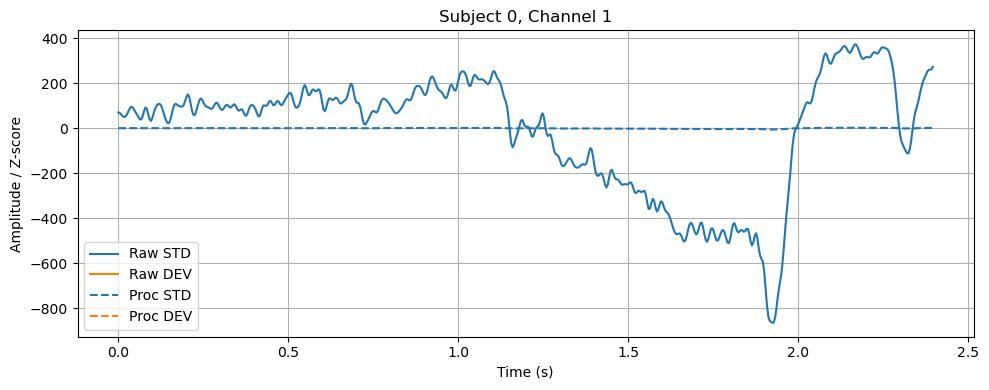

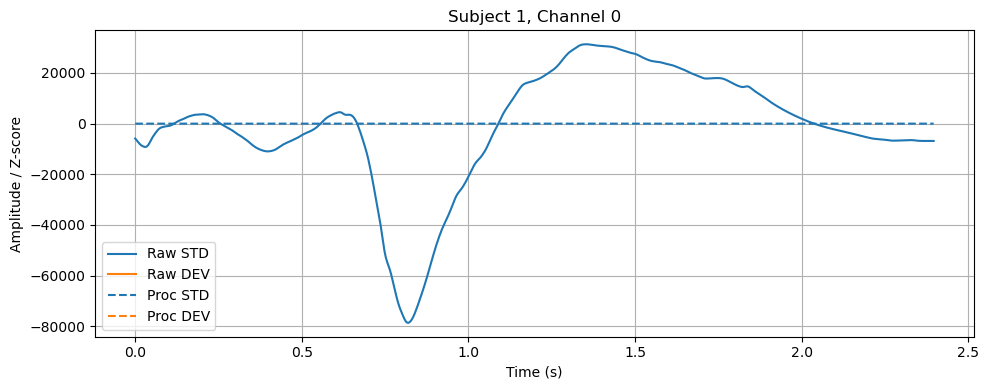

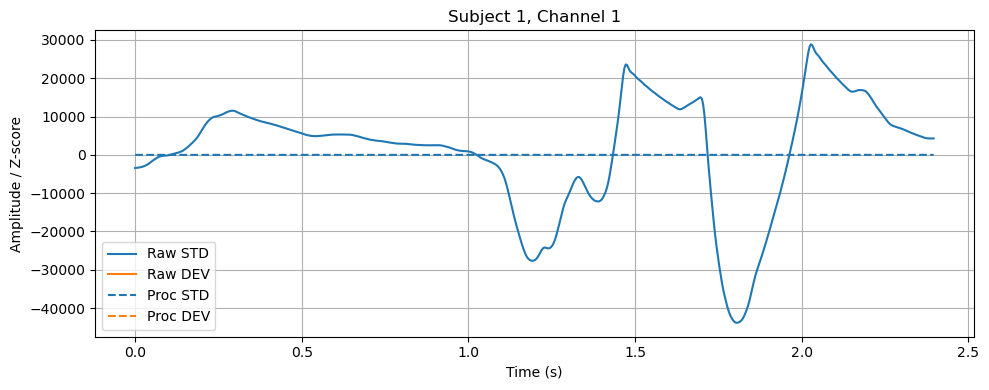

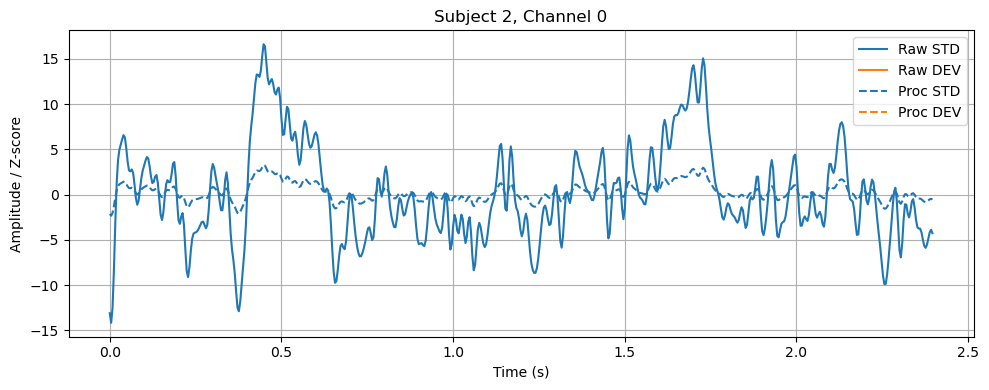

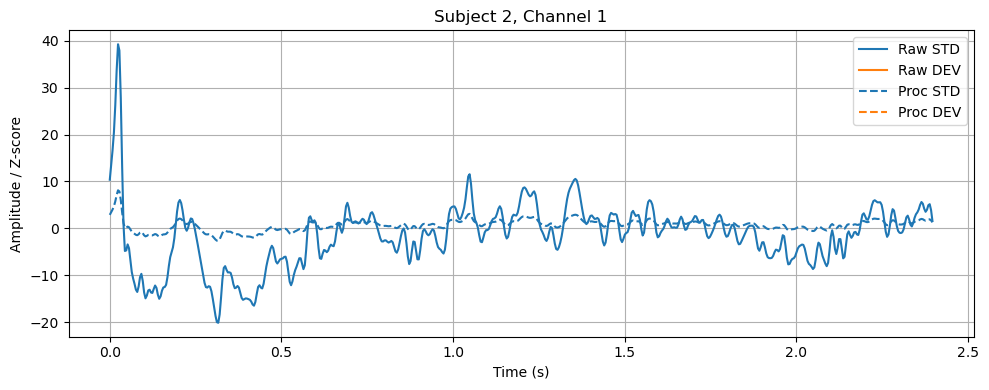

In [34]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

# 1) MAT 파일 로드
mat = scipy.io.loadmat('AD.mat')
subjects = mat['AD'][0]   # AD 구조체 배열

# 2) 시각화 대상 설정
sampling_rate = 250.0      # 예: 250 Hz
baseline_samples = 100     # baseline correction에 사용할 샘플 수

# 3) 반복 처리 함수
def preprocess_and_plot(subjects, channels_to_plot=None, max_subjects=5):
    """
    subjects      : 구조체 배열
    channels_to_plot : 시각화할 채널 인덱스 리스트 (None 이면 모든 채널)
    max_subjects  : 시각화할 최대 피험자 수
    """
    for subj_idx, subj in enumerate(subjects[:max_subjects]):
        epochs = subj['epoch']            # shape: (n_blocks, n_times, n_channels)
        odors  = subj['odor'].flatten()   # 길이 >= n_blocks
        noisy  = subj['noisy'].flatten()  # 길이 >= n_blocks
        
        # trial 단위로 noisy==0인 깨끗한 블록만 선택
        n_blocks = epochs.shape[0]
        mask = noisy[:n_blocks] == 0
        clean_epochs = epochs[mask]
        clean_odors  = odors[:n_blocks][mask]
        
        # 디폴트: 모든 채널 시각화
        n_channels = epochs.shape[2]
        ch_list = channels_to_plot or list(range(n_channels))
        
        # Standard(1) / Deviant(2) ERP 계산 (raw vs. processed)
        # raw ERP
        erp_raw_std = clean_epochs[clean_odors == 1].mean(axis=0)
        erp_raw_dev = clean_epochs[clean_odors == 2].mean(axis=0)
        # processed: baseline + z-score
        bc = clean_epochs - clean_epochs[:, :baseline_samples, :].mean(axis=1, keepdims=True)
        zc = (bc - bc.mean(axis=(1,2), keepdims=True)) / bc.std(axis=(1,2), keepdims=True)
        erp_proc_std = zc[clean_odors == 1].mean(axis=0)
        erp_proc_dev = zc[clean_odors == 2].mean(axis=0)
        
        time_axis = np.arange(erp_raw_std.shape[0]) / sampling_rate
        
        # 4) 피험자·채널별 플롯
        for ch in ch_list:
            plt.figure(figsize=(10, 4))
            plt.plot(time_axis, erp_raw_std[:, ch], label='Raw STD',    color='C0')
            plt.plot(time_axis, erp_raw_dev[:, ch], label='Raw DEV',    color='C1')
            plt.plot(time_axis, erp_proc_std[:, ch], label='Proc STD', linestyle='--', color='C0')
            plt.plot(time_axis, erp_proc_dev[:, ch], label='Proc DEV', linestyle='--', color='C1')
            plt.title(f'Subject {subj_idx}, Channel {ch}')
            plt.xlabel('Time (s)')
            plt.ylabel('Amplitude / Z-score')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

# 5) 실행: 처음 3명의 피험자, 채널 0과 1만 시각화
preprocess_and_plot(subjects, channels_to_plot=[0,1], max_subjects=3)


In [ ]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

# ← 여기에 AD.mat 파일의 실제 경로를 넣으세요
matfile = r'/path/to/AD.mat'

# 1) .mat 파일 로드
mat = scipy.io.loadmat(matfile)
subjects = mat['AD'][0]

# 2) Deviant(1) trial 있는 피험자 찾기
def find_subject_with_deviant(subjects):
    for idx, subj in enumerate(subjects):
        odors = subj['odor'].flatten()
        noisy_idx = subj['noisy'].flatten().astype(int) - 1
        mask = np.ones(len(odors), dtype=bool)
        mask[noisy_idx] = False
        if np.any(odors[mask] == 1):
            return idx, subj
    return None, None

subj_idx, subj = find_subject_with_deviant(subjects)
if subj_idx is None:
    raise RuntimeError("Deviant trial이 있는 피험자를 찾을 수 없습니다.")
print(f"Using Subject {subj_idx}")

# 3) 데이터 추출
epochs = subj['epoch']                 # (channels, time, trials)
odors  = subj['odor'].flatten()        # (trials,)
noisy_idx = subj['noisy'].flatten().astype(int) - 1

# 4) clean mask 생성
n_trials = epochs.shape[2]
mask_clean = np.ones(n_trials, dtype=bool)
mask_clean[noisy_idx] = False

# 5) (trial, time, chan) 으로 축 재배열
epochs = np.transpose(epochs, (2, 1, 0))  # → (trials, time, channels)

# 6) clean 데이터만 선택
clean_epochs = epochs[mask_clean]
clean_odors  = odors[mask_clean]
print("clean_epochs.shape:", clean_epochs.shape)
print("clean_odors dist:", {o: int((clean_odors == o).sum()) for o in np.unique(clean_odors)})

# 7) 전처리: baseline correction + z-score normalization
baseline_samps = 100
bc = clean_epochs - clean_epochs[:, :baseline_samps, :].mean(axis=1, keepdims=True)
zc = (bc - bc.mean(axis=(1,2), keepdims=True)) / bc.std(axis=(1,2), keepdims=True)

# 8) ERP 계산 (0=Standard, 1=Deviant)
erp_raw_std  = clean_epochs[clean_odors == 0].mean(axis=0)
erp_raw_dev  = clean_epochs[clean_odors == 1].mean(axis=0)
erp_proc_std = zc   [clean_odors == 0].mean(axis=0)
erp_proc_dev = zc   [clean_odors == 1].mean(axis=0)

# 9) ERP 시각화 (채널 0)
sfreq = 250.0
times = np.arange(erp_raw_std.shape[0]) / sfreq

plt.figure(figsize=(8,4))
plt.plot(times, erp_raw_std[:,0],  'b-',  label='Raw STD')
plt.plot(times, erp_raw_dev[:,0],  'r-',  label='Raw DEV')
plt.plot(times, erp_proc_std[:,0], 'b--', label='Proc STD')
plt.plot(times, erp_proc_dev[:,0], 'r--', label='Proc DEV')
plt.axhline(0, color='k', lw=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude / Z-score')
plt.title(f'Subject {subj_idx} – Channel 0 ERP')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


Noisy trial indices (0-based): [  0  52 117]
총 trial=120, clean=117, noisy=3
clean_epochs.shape: (117, 600, 4)
clean_odors unique: [0 1] counts: {0: 88, 1: 29}


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_2640\1611214297.py:36: RuntimeWarning: Mean of empty slice.
  erp_raw_dev  = clean_epochs[ clean_odors==2].mean(axis=0)
c:\Users\Minnie\anaconda3\Lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_2640\1611214297.py:38: RuntimeWarning: Mean of empty slice.
  erp_proc_dev = zc[ clean_odors==2].mean(axis=0)


NameError: name 'subj_idx' is not defined

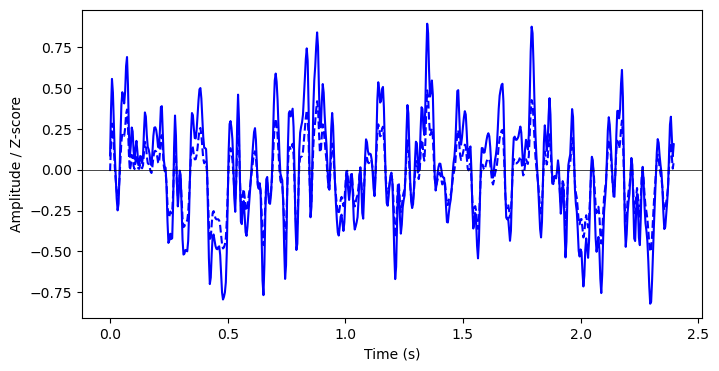

In [49]:
import numpy as np

# 1) 원본 배열들
epochs = subj['epoch']      # (chan=4, time=600, trial=120)
odors  = subj['odor'].squeeze()   # (120,)
n_trials = epochs.shape[2]  # 120

# 2) noisy indices 가져오기 (MATLAB이 1-based indexing이므로 -1 해 줌)
noisy_idx = subj['noisy'].flatten().astype(int) - 1  
print("Noisy trial indices (0-based):", noisy_idx)

# 3) clean mask 생성
mask_clean = np.ones(n_trials, dtype=bool)
mask_clean[noisy_idx] = False
print(f"총 trial={n_trials}, clean={mask_clean.sum()}, noisy={(~mask_clean).sum()}")

# 4) trial 축 앞으로 이동 → (trial, time, chan)
epochs = np.transpose(epochs, (2,1,0))  # → (120, 600, 4)

# 5) clean data만 골라내기
clean_epochs = epochs[mask_clean]      # (n_clean, 600, 4)
clean_odors  = odors [mask_clean]      # (n_clean,)

# 확인
print("clean_epochs.shape:", clean_epochs.shape)
print("clean_odors unique:", np.unique(clean_odors), "counts:", 
      {o:int((clean_odors==o).sum()) for o in np.unique(clean_odors)})

# 6) 전처리 예: baseline-correction + z-scoring
baseline_samps = 100
bc = clean_epochs - clean_epochs[:, :baseline_samps, :].mean(axis=1, keepdims=True)
zc = (bc - bc.mean(axis=(1,2), keepdims=True)) / bc.std(axis=(1,2), keepdims=True)

# 7) ERP 계산 (채널 0만 예시)
erp_raw_std  = clean_epochs[ clean_odors==1].mean(axis=0)  # (600,4)
erp_raw_dev  = clean_epochs[ clean_odors==2].mean(axis=0)
erp_proc_std = zc[ clean_odors==1].mean(axis=0)
erp_proc_dev = zc[ clean_odors==2].mean(axis=0)

# 8) 그리기
import matplotlib.pyplot as plt

sfreq = 250  # 데이터 샘플링 레이트(Hz), 논문이나 파일 헤더 보고 맞게 설정
times = np.arange(erp_raw_std.shape[0]) / sfreq

plt.figure(figsize=(8,4))
plt.plot(times, erp_raw_std [:,0], 'b-',  label='Raw STD')
plt.plot(times, erp_raw_dev [:,0], 'r-',  label='Raw DEV')
plt.plot(times, erp_proc_std[:,0], 'b--', label='Proc STD')
plt.plot(times, erp_proc_dev[:,0], 'r--', label='Proc DEV')
plt.axhline(0, color='k', lw=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude / Z-score')
plt.title(f'Subject {subj_idx} – Channel 0 ERP')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
